<h1> Training Notebook for Model 2 </h1>

In [2]:
# Loading libraries
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt

import glob
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import json

import pickle


import keras
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

import cv2

from keras.optimizers import Adam



In [ ]:
# please set this variable to where you cloned the git repo "final-project-code-nathanheck255"

filepath = "/blue/eel6825/nathan.heck/FinalProject/final-project-code-nathanheck255"
os.chdir(filepath)

# make sure you have extracted the Training Data before you proceed with the rest of the notebook
# with something like "unzip TrainingData.zip"

<h1> Load in the training data and calculate the spectrogram for each file </h1>

In [24]:
os.chdir("TrainingData/AudioSamples")
folder_names = glob.glob("*")
x_train = []
t_train = []
i=0
for instrument in folder_names:
    os.chdir(instrument)
    file_names = glob.glob("*.wav")
    for wav in file_names:
        waveform, samplerate = librosa.load(wav, sr=22050, mono=True)
        waveform = librosa.util.fix_length(waveform, size=32600)
        spec = librosa.feature.melspectrogram(y=waveform, sr=samplerate, n_fft = 512, hop_length = 256)
        normalized_spec = librosa.util.normalize(spec)
        x_train.append(normalized_spec)
        t_train.append(i)
        #np.save("/blue/eel6825/nathan.heck/FinalProject/Spectrograms/"+wav, normalized_spec)
    os.chdir("..")
    i=i+1
    
    
    
x_train = np.array(x_train)
x_train = x_train[..., np.newaxis]

os.chdir(filepath)

<h1> Let's plot a few of the spectrograms so we know what each class looks like </h1>

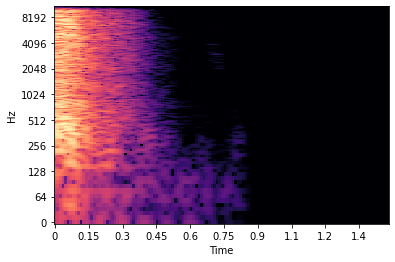

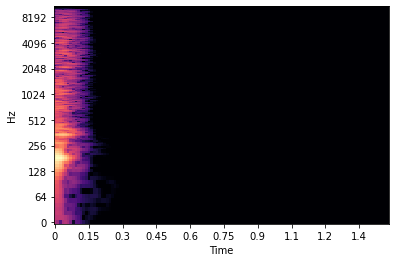

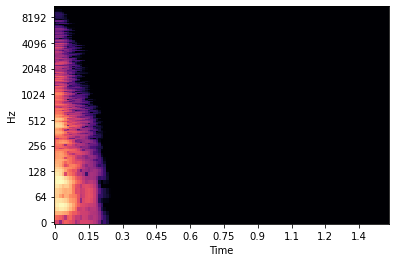

In [25]:
plt.figure()
filename = "TrainingData/AudioSamples/Hihat/Acoustic Closed Hat 01.wav"
y, sr = librosa.load(filename, sr=22050, mono=True)
y = librosa.util.fix_length(y, size=32600)
y_harm, y_perc = librosa.effects.hpss(y)

hop_length = 256
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc, hop_length=hop_length)),
                            ref=np.max)

librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time')


plt.figure()
filename = "TrainingData/AudioSamples/Snare/Acoustic Snare 01.wav"
y, sr = librosa.load(filename, sr=22050, mono=True)
y = librosa.util.fix_length(y, size=32600)
y_harm, y_perc = librosa.effects.hpss(y)

hop_length = 256
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc, hop_length=hop_length)),
                            ref=np.max)

librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time')


plt.figure()
filename = "TrainingData/AudioSamples/Kick/Acoustic Kick 01.wav"
y, sr = librosa.load(filename, sr=22050, mono=True)
y = librosa.util.fix_length(y, size=32600)
y_harm, y_perc = librosa.effects.hpss(y)

hop_length = 256
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_perc, hop_length=hop_length)),
                            ref=np.max)

librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time')



plt.show()

<h1> Building the Autoencoder </h1>

In [26]:
input_img = keras.Input(shape=(128, 128, 1))

###
# Define the encoder of an autoencoder. 
# It should take in the 'input_img' variable, and output the encoded input, with a chosen number of dimensions
# Define multiple sets of {convolutional, maxpooling} layers.
# YOUR CODE BELOW

#encoded
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#
###


###
# Define the decoder of our autoencoder. 
# It should take in the 'encoded' variable, and output the decoded input, here the same dimensions as the input (128, 128, 1).
# Define multiple sets of {convolutional, upsampling} layers.
# YOUR CODE BELOW
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

#
###

autoencoder = keras.Model(input_img, decoded)

# Feel free to play around with the learning rate.
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

<h1> Training the Autoencoder </h1>

In [27]:
print(x_train.shape)
autoencoder.fit(x_train, x_train,
               epochs=10,
               batch_size=128,
               shuffle=True,
               callbacks=[TensorBoard(log_dir="logs")])

(918, 128, 128, 1)
Epoch 1/10
8/8 [==============================] - 14s 2s/step - loss: 0.0103
Epoch 2/10
8/8 [==============================] - 14s 2s/step - loss: 0.0094
Epoch 3/10
8/8 [==============================] - 14s 2s/step - loss: 0.0078
Epoch 4/10
8/8 [==============================] - 14s 2s/step - loss: 0.0070
Epoch 5/10
8/8 [==============================] - 14s 2s/step - loss: 0.0065
Epoch 6/10
8/8 [==============================] - 14s 2s/step - loss: 0.0060
Epoch 7/10
8/8 [==============================] - 14s 2s/step - loss: 0.0056
Epoch 8/10
8/8 [==============================] - 14s 2s/step - loss: 0.0053
Epoch 9/10
8/8 [==============================] - 14s 2s/step - loss: 0.0051
Epoch 10/10
8/8 [==============================] - 14s 2s/step - loss: 0.0050


<h1> Encode all the spectrograms into the latent variable space </h1>

<p> Separate the encoder part of that model and save that to a file we can use later. </p>

In [28]:
encoder=keras.Model(input_img, encoded)
encoder_output = encoder.predict(x_train)
encoder.save("encoder.h5")


29/29 [==============================] - 2s 70ms/step


<h1> Visualize the different classes spread across part of the latent space </h1>

(918, 2048)


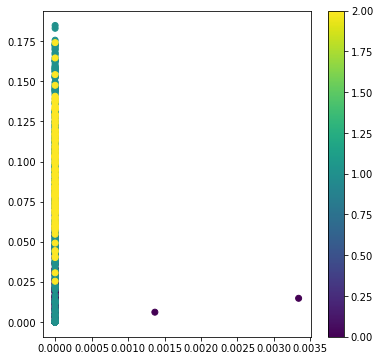

In [29]:
latents = np.reshape(encoder_output, [918, 16*16*8])
print(latents.shape)
plt.figure(figsize=(6, 6))
plt.scatter(latents[:, 0], latents[:, 1], c=t_train)
plt.colorbar()
plt.show()

<h1> Building the CNN </h1>

In [30]:
t = np.array(t_train)

X_train, X_val, y_train, y_val = train_test_split(encoder_output, t, test_size=0.2, stratify=t)

# Neural network
model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(encoder_output.shape[1], encoder_output.shape[2], encoder_output.shape[3])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu'),

        # output layer
        keras.layers.Dense(3, activation='softmax')
])
    
optimiser = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,197,059
Trainable params: 1,197,059
Non-trainable params: 0
_________________________________________________________________


<h1> Training the CNN on the features from the CAE </h1>

In [31]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30)
model.save('model2.h5')

Epoch 1/30
23/23 [==============================] - 0s 11ms/step - loss: 0.9724 - accuracy: 0.5518 - val_loss: 0.8385 - val_accuracy: 0.6359
Epoch 2/30
23/23 [==============================] - 0s 7ms/step - loss: 0.7117 - accuracy: 0.6962 - val_loss: 0.6246 - val_accuracy: 0.6957
Epoch 3/30
23/23 [==============================] - 0s 7ms/step - loss: 0.5171 - accuracy: 0.8311 - val_loss: 0.4436 - val_accuracy: 0.9076
Epoch 4/30
23/23 [==============================] - 0s 7ms/step - loss: 0.3859 - accuracy: 0.9046 - val_loss: 0.3287 - val_accuracy: 0.9239
Epoch 5/30
23/23 [==============================] - 0s 7ms/step - loss: 0.2979 - accuracy: 0.9251 - val_loss: 0.2609 - val_accuracy: 0.9348
Epoch 6/30
23/23 [==============================] - 0s 7ms/step - loss: 0.2345 - accuracy: 0.9305 - val_loss: 0.2174 - val_accuracy: 0.9348
Epoch 7/30
23/23 [==============================] - 0s 7ms/step - loss: 0.1970 - accuracy: 0.9360 - val_loss: 0.1883 - val_accuracy: 0.9402
Epoch 8/30
23/23 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


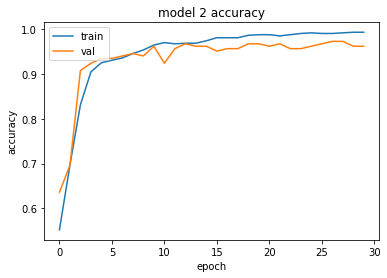

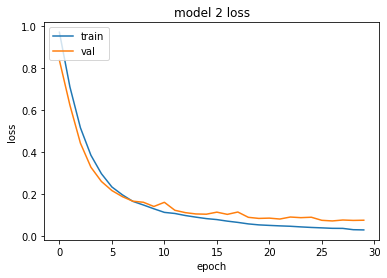

In [32]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()